In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import os

import glob
import random
%matplotlib inline
from skimage.feature import *
from tqdm import tqdm
from skimage.measure import label, regionprops, find_contours
from sklearn.model_selection import train_test_split

#from google.colab.patches import cv2_imshow

In [8]:
kernel = np.ones((7,7),np.uint8)

class Segmentation(object):

    def __init__(self, Image):
        self.Image = Image
        
    def binarization(self):
        ret, thresh1 = cv2.threshold(self.Image,30,255,cv2.THRESH_BINARY)
        # convert to white
        closing1 = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel)

        # save to /tmp folder
        cv2.imwrite("imgs/thresh1.jpg", thresh1)
        cv2.imwrite("imgs/closing1.jpg", closing1)
        
        return closing1, thresh1

    # removing skul
    def removing_skul(self, closing1):
        erosion = cv2.erode(closing1,kernel,iterations = 6)
        NO_skull = self.Image * (-erosion)

        # save to /tmp folder
        cv2.imwrite("imgs/NO_skull.jpg", NO_skull)
        cv2.imwrite("imgs/erosion.jpg", erosion)
        
        return NO_skull, erosion
    
    # enhance image to segmentation
    def enhance_image_t_seg(self, NO_skull):
        median = cv2.medianBlur(NO_skull,5)
        blur = cv2.GaussianBlur(median,(5,5),0)

        # save to /tmp folder
        #cv2.imwrite("imgs/blur.jpg", blur)
        
        return blur
    
    def to_Segmentation(self, blur):
        ret, thresh2 = cv2.threshold(blur,120,255,cv2.THRESH_BINARY)
        img = thresh2
        # Remove noise
        no_noise = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

        # save to /tmp folder
        cv2.imwrite("imgs/no_noise.jpg", no_noise)
        cv2.imwrite("imgs/thresh2.jpg", thresh2)
       
        return no_noise, thresh2
    
    # edge detection
    def Edge_Detection(self,thresh2):
        edges = cv2.Canny(thresh2,100,200)

        # save to /tmp folder
        cv2.imwrite("imgs/edges.jpg", edges)
        
        return edges

In [9]:
class Preprocessing(object):
    grayImage   = ''
    image       = ''
    closing1    = ''
    thresh1     = ''
    NO_skull    = ''
    erosion     = ''
    blur        = ''
    no_noise    = ''
    edge        = ''
    tumourImage = ''
    
    def preproces(self, originalImageUrl):
        self.url = originalImageUrl
        image = cv2.imread(originalImageUrl)
        self.grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        self.image = Segmentation(self.grayImage)

    # binarization
    def binarization(self):
        self.closing1, self.thresh1 = self.image.binarization()
        #plt.imshow(closing1,'gray')

    # removing_skul
    def removingSkul(self):
        self.NO_skull, self.erosion = self.image.removing_skul(self.closing1)
        #plt.imshow(NO_skull,'gray')

    # enhance image to segmentation
    def enhanceImage(self):
        self.blur = self.image.enhance_image_t_seg(self.NO_skull)
        #plt.imshow(blur,'gray')

    # Segmentation
    def segmentation(self):
        self.no_noise, self.thresh2 = self.image.to_Segmentation(self.blur)
        #plt.imshow(no_noise,'gray')

        self.edge = self.image.Edge_Detection(self.thresh2)

        # Plot
        #segm.Show_plots(img,thresh1,closing1,erosion,blur,NO_skull,no_noise)

    def getInfectedRegion(self,cls):
        col1 = 0
        col2 = 0
        row1 = 0
        row2 = 0
        
        for i in range(self.no_noise.shape[1]):
            for j in range(self.no_noise.shape[0]):
                if self.no_noise.item(j, i) > 0:
                    if col1 == 0 & col2 == 0:
                        col1 = j
                        row1 = i
                    else:
                        if col1 > j:
                            col1 = j
                        else:
                            if col2 < j:
                                col2 = j
                            
                        if row1 > i:
                            row1 = i
                        else:
                            if row2 < i:
                                row2 = i

        # draw rectangle to select tumour region                    
        cv2.rectangle(self.no_noise, (row1, col1), (row2, col2), (255,0,0), 2)

        # save again for good preview 
#         cv2.imwrite("./tmp/no_noise.jpg", self.no_noise)

        # tumourImage
        self.tumourImage = self.no_noise[col1:col2, row1:row2]
    
        
        #plt.imshow(self.tumourImage, "gray")
        if col1==0 or col2 ==0 or row1==0 or row2==0:
            pass
        
        print(col1, col2, row1, row2)
        if self.tumourImage is not None and (row2-row1)>0 and (col2-col1)>0:
            if cls==1:
                cv2.imwrite(str("imgs/pos_" + self.url.split('/')[-1]), self.tumourImage)
            else:
                cv2.imwrite(str("imgs/neg_" + self.url.split('/')[-1]), self.tumourImage)

        
        
        return col1, col2, row1, row2

In [10]:
from os import listdir
from os.path import isfile, join

In [11]:
path = "no"
neg_images = [str(path + "/" +f) for f in listdir(path) if isfile(join(path, f))]

In [18]:
print(len(neg_images))

98


In [19]:
neg_images[0]

'no/1 no.jpeg'

In [12]:
preprocessing = Preprocessing()
count = 0
for im in neg_images:
    #print(count)
    preprocessing.preproces(im)
    preprocessing.binarization()
    preprocessing.removingSkul()
    preprocessing.enhanceImage()
    preprocessing.segmentation()
    preprocessing.getInfectedRegion(0)
    count += 1
    
print(count)

233 386 190 440
0 0 0 0
0 0 0 0
41 127 104 170
0 0 0 0
47 142 42 126
1 193 142 183
0 0 0 0
0 0 0 0
0 0 0 0
235 416 228 445
43 213 40 158
41 135 91 137
36 204 44 179
26 214 38 190
40 182 41 180
51 188 49 165
160 187 16 38
0 0 0 0
71 250 0 142
89 95 74 80
79 174 58 158
12 241 0 204
244 251 92 106
86 170 75 131
83 131 85 137
104 118 0 4
121 145 91 123
78 148 94 147
0 0 0 0
134 174 90 113
77 141 104 137
94 167 68 135
146 169 79 142
146 169 79 142
0 0 0 0
56 160 90 171
77 317 123 339
92 390 61 291
93 429 62 316
0 0 0 0
92 537 278 486
0 0 0 0
0 0 0 0
0 0 0 0
72 86 91 101
291 352 316 359
134 174 90 113
0 0 0 0
5 298 36 236
0 0 0 0
43 194 54 170
112 181 93 132
74 302 153 247
68 79 84 94
37 221 27 178
62 190 54 89
112 894 200 820
115 205 103 223
49 217 40 164
145 190 69 125
94 167 68 135
39 196 40 165
0 0 0 0
167 626 196 565
0 0 0 0
81 119 110 122
79 149 69 161
145 190 69 125
0 0 0 0
31 144 28 182
100 516 150 474
101 252 278 299
0 0 0 0
191 971 589 1218
47 241 131 285
118 325 171 282
0 0 0 0
0 

In [13]:
path = "yes"
pos_images = [str(path + "/" +f) for f in listdir(path) if isfile(join(path, f))]

In [14]:
preprocessing = Preprocessing()
count = 0
for im in pos_images:
    #print(count)
    preprocessing.preproces(im)
    preprocessing.binarization()
    preprocessing.removingSkul()
    preprocessing.enhanceImage()
    preprocessing.segmentation()
    preprocessing.getInfectedRegion(1)
    count += 1
    
print(count)

41 171 27 145
38 349 13 303
126 313 105 226
129 167 126 141
43 629 73 499
29 988 27 790
1 889 401 641
30 215 39 161
38 156 27 148
87 447 101 368
94 1052 139 846
1 278 149 257
158 337 73 206
39 323 0 271
24 267 3 250
18 274 37 206
102 161 65 113
46 254 38 210
37 227 31 205
53 245 44 194
66 462 2 346
37 211 33 118
27 294 33 216
34 299 47 246
26 270 2 262
1 351 217 312
1 282 132 230
1 351 309 309
37 322 49 248
35 335 66 399
38 216 62 271
71 318 71 222
158 275 111 201
40 330 52 234
51 308 40 252
69 304 41 284
154 211 178 235
68 281 26 240
94 1052 139 846
40 276 45 163
31 104 99 181
191 225 38 66
32 261 31 220
2 345 2 266
42 247 48 209
27 294 33 216
34 299 47 246
147 154 156 162
117 298 46 224
1 585 446 466
1 351 309 309
281 291 120 131
23 281 6 299
82 155 57 188
30 359 23 295
30 408 75 310
81 152 40 111
0 0 0 0
166 216 181 234
102 204 123 181
158 239 50 94
72 94 133 164
4 157 150 244
48 211 48 140
75 229 104 211
41 216 31 175
43 330 40 241
138 241 168 215
102 519 469 760
25 88 89 133
76 18

# Feature Extraction

In [16]:
from skimage.measure import *
from skimage import data
from scipy.stats import kurtosis, skew
from skimage.color import rgb2gray
from skimage.feature import greycomatrix, greycoprops
from skimage.io import imread

import skimage
from skimage import measure

In [17]:
ds = []
crr = []
cn = []
am = []
en = []
ho = []

Class = []
av_kur1 = []
av_sk1 = []
std = []
Mean = []


centroid = []
area = []
extent = []
orientation = []
convex_area = []
solidity = []
eccentricity = []
euler_number = []

In [18]:
path = "imgs"
images = [str(path + "/" +f) for f in listdir(path) if isfile(join(path, f))]

In [19]:
tpath = images[0]
images[0].split('_')[0].split("/")[-1]

'neg'

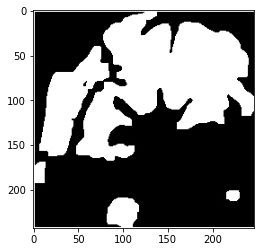

In [20]:
ipath = "imgs/pos_Y112.JPG"
im = io.imread(ipath)
plt.imshow(im, "gray")

In [28]:
print(skew(im.reshape(-1)), kurtosis(im.reshape(-1)))

0.3899048620046259 -1.8478820572850039


In [21]:
for img_path in images:
    im = io.imread(img_path)
    m = skimage.measure.moments(im)
    cr = m[0,1] / m[0,0]
    cc = m[1,0] / m[0,0]
    #measure.moments_central(im, cr, cc)
    label_img = label(im, connectivity=im.ndim)
    props = regionprops(label_img)
    
    area.append(props[0].area)
    extent.append(props[0].extent)
    orientation.append(props[0].orientation)
    convex_area.append(props[0].convex_area)
    solidity.append(props[0].solidity)
    eccentricity.append(props[0].eccentricity)
    euler_number.append(props[0].euler_number)
    if img_path.split('_')[0].split("/")[-1] == "pos":
        Class.append(1)
    else:
        Class.append(0)
        
    
    glcm = greycomatrix(im, [5], [0], symmetric=True, normed=True)
    ds.append(greycoprops(glcm, 'dissimilarity')[0,0])
    crr.append(greycoprops(glcm, 'correlation')[0,0])
    cn.append(greycoprops(glcm, 'contrast')[0,0])
    am.append(greycoprops(glcm, 'ASM')[0,0])
    en.append(greycoprops(glcm, 'energy')[0,0])
    ho.append(greycoprops(glcm, 'homogeneity')[0,0])
    
    av_kur1.append(kurtosis(im.reshape(-1)))
    av_sk1.append(skew(im.reshape(-1)))
    Mean.append(im.mean())
    std.append(im.std())
    
    
    

C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in v

In [22]:
df = pd.DataFrame({'area' : area,
                  'extent' : extent,
                  'orientation' : orientation,
                  'convex_area' : convex_area,
                  'solidity' : solidity,
                  'eccentricity' : eccentricity,
                  'euler_number' : euler_number,
                  'dissimilarity' : ds,
                  'correlation' : crr,
                  'contrast' : cn,
                  'ASM' : am,
                  'energy' : en,
                  'homogeneity' : ho,
                  'kurtosis' : av_kur1,
                  'skew' : av_sk1,
                  'Standard Deviation' : std,
                  'Mean':Mean,
                  'Class' : Class
                  })

In [23]:
df

,area,extent,orientation,convex_area,solidity,eccentricity,euler_number,dissimilarity,correlation,contrast,ASM,energy,homogeneity,kurtosis,skew,Standard Deviation,Mean,Class
0,698,0.018248,1.199475,27801,0.025107,0.891050,-3,7.286515,0.643807,1846.896279,0.858411,0.926505,0.961245,15.861367,4.226219,54.483944,12.263373,0
1,275,0.260417,-1.418901,717,0.383543,0.979575,-24,21.596454,0.587089,5465.415745,0.612204,0.782435,0.871061,2.382263,2.093331,87.943329,35.340909,0
2,1,1.000000,0.785398,1,1.000000,0.000000,1,65.917388,0.475314,16627.100600,0.133810,0.365801,0.574493,-1.928495,0.267018,125.957334,110.615789,0
3,1,1.000000,0.785398,1,1.000000,0.000000,1,39.595920,0.550581,10024.703270,0.420417,0.648396,0.781456,-0.662920,1.156252,110.189867,63.709350,0
4,1,1.000000,0.785398,1,1.000000,0.000000,1,5.444387,0.676617,1381.894819,0.887615,0.942133,0.971954,19.124857,4.596138,50.843298,10.599180,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,224,0.888889,-0.196511,252,0.888889,0.622843,-8,6.641975,-0.010146,1593.864198,0.602709,0.776343,0.834423,57.976191,-7.742957,31.792598,250.789683,1
222,1,1.000000,0.785398,1,1.000000,0.000000,1,24.153113,0.691433,6092.642047,0.516334,0.718564,0.841242,0.463204,1.569393,100.107620,48.785858,1
223,897,0.036654,-0.405708,12799,0.070084,0.858660,-25,23.024839,0.781802,5819.006242,0.428654,0.654717,0.860885,-1.171209,0.910325,115.914477,74.693568,1
224,49,1.000000,0.785398,49,1.000000,0.000000,1,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-3.000000,0.000000,0.000000,255.000000,1


In [48]:
from sklearn.model_selection import train_test_split
x= df.drop(columns=['Class'])
y=df['Class'] 

In [49]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.3)

# Evaluating the saved KNN model

In [24]:
import pickle

model = pickle.load(open('savedKnnModel.sav', 'rb'))

In [25]:
df.drop(['solidity','euler_number' , 'extent'], 1 , inplace=True)

C:\Users\hari\AppData\Local\Temp\ipykernel_16004\1364300657.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['solidity','euler_number' , 'extent'], 1 , inplace=True)


In [56]:
y=ds['Class']

In [57]:
neg=ds[ds['Class'] ==0]
pos= ds[ds['Class'] ==1]


In [60]:
neg.drop(['Class'], 1 , inplace=True)
pos.drop(['Class'], 1 , inplace=True)

C:\Users\hari\AppData\Local\Temp\ipykernel_16004\2217051096.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  neg.drop(['Class'], 1 , inplace=True)
C:\Users\hari\AppData\Local\Temp\ipykernel_16004\2217051096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg.drop(['Class'], 1 , inplace=True)
C:\Users\hari\AppData\Local\Temp\ipykernel_16004\2217051096.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pos.drop(['Class'], 1 , inplace=True)
C:\Users\hari\AppData\Local\Temp\ipykernel_16004\2217051096.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

In [61]:
yn=ds[ds['Class'] == 0]
yp=df[df['Class'] ==1]

In [62]:

yp=yp['Class']
yn=yn['Class']

In [65]:
print(len(pos))
print(len(neg))

149
77


In [64]:
model.score(pos,yp)

0.9932885906040269

# Naive Classification

In [34]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [35]:
model.fit(x_train,y_train)

C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [50]:
print("Accuracy : ",model.score(x_test,y_test))

Accuracy :  0.6911764705882353


In [37]:
from sklearn.tree import DecisionTreeClassifier
dTreemodel= DecisionTreeClassifier()

In [38]:
dTreemodel.fit(x_train,y_train)

DecisionTreeClassifier()

In [39]:
print("Accuracy : ",dTreemodel.score(x_test,y_test))

Accuracy :  0.6571428571428571


# Improving the performance

In [40]:
df.drop(['solidity','euler_number' , 'extent'], 1 , inplace=True)

C:\Users\hari\AppData\Local\Temp\ipykernel_19308\1364300657.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['solidity','euler_number' , 'extent'], 1 , inplace=True)


In [44]:
ds_class_1 = df[df['Class'] > 0]

In [45]:
ds_class_1.loc[0:,'Mean'] = (ds_class_1['Mean']) / ds_class_1['Mean'].std()
ds_class_1.loc[0:,'ASM'] = (ds_class_1['ASM']  / ds_class_1['ASM'].std()) 
ds_class_1.loc[0:,'contrast'] = (ds_class_1['contrast']) / ds_class_1['contrast'].std()
ds_class_1.loc[0:,'correlation'] = (ds_class_1['correlation']  /  ds_class_1['correlation'].std()) 
ds_class_1.loc[0:,'dissimilarity'] = (ds_class_1['dissimilarity'] / ds_class_1['dissimilarity'].std())
ds_class_1.loc[0:,'energy'] = (ds_class_1['energy']  /  ds_class_1['energy'].std())
ds_class_1.loc[0:,'kurtosis'] = (ds_class_1['kurtosis'] /  ds_class_1['kurtosis'].std())
ds_class_1.loc[0:,'skew'] = (ds_class_1['skew']  / ds_class_1['skew'].std())
ds_class_1.loc[0:,'Standard Deviation'] = (ds_class_1['Standard Deviation']  / ds_class_1['Standard Deviation'].std())
ds_class_1.loc[0:,'area'] = (ds_class_1['area']) / ds_class_1['area'].std()
ds_class_1.loc[0:,'homogeneity'] = (ds_class_1['homogeneity']  / ds_class_1['homogeneity'].std()) 
ds_class_1.loc[0:,'orientation'] = (ds_class_1['orientation']  /  ds_class_1['orientation'].std()) 
ds_class_1.loc[0:,'convex_area'] = (ds_class_1['convex_area'] / ds_class_1['convex_area'].std())
ds_class_1.loc[0:,'eccentricity'] = (ds_class_1['eccentricity'] /  ds_class_1['eccentricity'].std())

C:\Users\hari\AppData\Local\Temp\ipykernel_16004\3613918289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_class_1.loc[0:,'Mean'] = (ds_class_1['Mean']) / ds_class_1['Mean'].std()
C:\Users\hari\AppData\Local\Temp\ipykernel_16004\3613918289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_class_1.loc[0:,'ASM'] = (ds_class_1['ASM']  / ds_class_1['ASM'].std())
C:\Users\hari\AppData\Local\Temp\ipykernel_16004\3613918289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [46]:
ds_class_0 = df[df['Class'] < 1]

In [52]:
ds_class_0.loc[0:,'Mean'] = (ds_class_0['Mean']) / ds_class_0['Mean'].std()
ds_class_0.loc[0:,'ASM'] = (ds_class_0['ASM']  / ds_class_0['ASM'].std()) 
ds_class_0.loc[0:,'contrast'] = (ds_class_0['contrast']) / ds_class_0['contrast'].std()
ds_class_0.loc[0:,'correlation'] = (ds_class_0['correlation']  /  ds_class_0['correlation'].std()) 
ds_class_0.loc[0:,'dissimilarity'] = (ds_class_0['dissimilarity'] / ds_class_0['dissimilarity'].std())
ds_class_0.loc[0:,'energy'] = (ds_class_0['energy']  /  ds_class_0['energy'].std())
ds_class_0.loc[0:,'kurtosis'] = (ds_class_0['kurtosis'] /  ds_class_0['kurtosis'].std())
ds_class_0.loc[0:,'skew'] = (ds_class_0['skew']  / ds_class_0['skew'].std())
ds_class_0.loc[0:,'Standard Deviation'] = (ds_class_0['Standard Deviation']  / ds_class_0['Standard Deviation'].std())
ds_class_0.loc[0:,'area'] = (ds_class_0['area']) / ds_class_0['area'].std()
ds_class_0.loc[0:,'homogeneity'] = (ds_class_0['homogeneity']  / ds_class_0['homogeneity'].std()) 
ds_class_0.loc[0:,'orientation'] = (ds_class_0['orientation']  /  ds_class_0['orientation'].std()) 
ds_class_0.loc[0:,'convex_area'] = (ds_class_0['convex_area'] / ds_class_0['convex_area'].std())
ds_class_0.loc[0:,'eccentricity'] = (ds_class_0['eccentricity'] /  ds_class_0['eccentricity'].std())

C:\Users\hari\AppData\Local\Temp\ipykernel_16004\2367797386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_class_0.loc[0:,'Mean'] = (ds_class_0['Mean']) / ds_class_0['Mean'].std()
C:\Users\hari\AppData\Local\Temp\ipykernel_16004\2367797386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_class_0.loc[0:,'ASM'] = (ds_class_0['ASM']  / ds_class_0['ASM'].std())
C:\Users\hari\AppData\Local\Temp\ipykernel_16004\2367797386.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [54]:
frames = [ds_class_1 , ds_class_0]
ds = pd.concat(frames, ignore_index=True)

In [46]:
ds

,area,orientation,convex_area,eccentricity,dissimilarity,correlation,contrast,ASM,energy,homogeneity,kurtosis,skew,Standard Deviation,Mean,Class
0,0.000923,1.623689,0.000344,0.000000,2.664735,3.901782,2.661502,1.387249,3.658446,7.720315,-0.298280,-0.256649,4.762927,2.535662,1
1,0.000923,1.623689,0.000344,0.000000,1.740378,4.643811,1.735584,1.605592,3.935836,8.525695,-0.318584,0.095865,4.839401,1.981872,1
2,0.000923,1.623689,0.000344,0.000000,1.704708,4.084932,1.703916,2.505692,4.916807,8.710269,-0.034572,0.895672,4.033971,0.949021,1
3,0.000923,1.623689,0.000344,0.000000,5.956381,1.420107,5.956484,0.563534,2.331737,5.057539,-0.283004,-0.329368,4.701714,2.641400,1
4,0.000923,1.623689,0.000344,0.000000,1.039961,4.547582,1.038182,3.175266,5.534895,9.340153,0.188765,1.194093,3.623793,0.714982,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0.000041,1.201320,0.000018,0.000000,0.831944,3.086067,0.828356,2.621261,4.099930,5.568067,0.425361,1.376151,2.249288,0.398543,0
227,0.016090,-0.420268,0.009681,2.370675,0.243798,3.078022,0.242615,3.460163,4.710528,6.021859,3.320424,3.230688,1.170325,0.098421,0
228,0.000041,1.201320,0.000018,0.000000,0.603484,3.945486,0.162907,0.620127,1.994167,2.909662,0.175430,0.614620,1.326240,0.607420,0
229,0.000041,1.201320,0.000018,0.000000,1.337109,3.465797,1.328036,1.537499,3.139994,5.095306,-0.085359,-0.621772,3.105474,2.598349,0


In [55]:
x= ds.drop(columns=['Class'])
y=ds['Class']

In [48]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.3)

In [49]:
model.fit(x_train,y_train)

LogisticRegression()

In [50]:
print("Accuracy : ",model.score(x_test,y_test))

Accuracy :  0.9857142857142858


In [51]:
import pickle
filename='model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [1]:
import pickle
import helpers
import extract_features as exf

In [5]:
im_path='3 no.jpg'

       
preprocessing = helpers.Preprocessing()
preprocessing.preproces(im_path)
preprocessing.binarization()
preprocessing.removingSkul()
preprocessing.enhanceImage()
preprocessing.segmentation()
preprocessing.getInfectedRegion()
ip = exf.extract_features('tmp/'+im_path)
print(ip)
model = pickle.load(open('model.pkl', 'rb'))
print(model.predict([ip]))

79 174 58 158
[519.0, -1.1829333902525447, 5414.0, 0.8755541357956672, 23.067257617728533, 0.5660714422773488, 5832.288531855955, 0.6007216703370908, 0.7750623654500912, 0.8637865432672389, 2.6985230233286446, 2.167540679592984, 86.32489683763137, 33.83915789473684]
[1]


C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
C:\Users\hari\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in v

In [6]:
ds_class_0.loc[0:,'Mean'] = (ds_class_0['Mean']) / ds_class_0['Mean'].std()
ds_class_0.loc[0:,'ASM'] = (ds_class_0['ASM']  / ds_class_0['ASM'].std()) 
ds_class_0.loc[0:,'contrast'] = (ds_class_0['contrast']) / ds_class_0['contrast'].std()
ds_class_0.loc[0:,'correlation'] = (ds_class_0['correlation']  /  ds_class_0['correlation'].std()) 
ds_class_0.loc[0:,'dissimilarity'] = (ds_class_0['dissimilarity'] / ds_class_0['dissimilarity'].std())
ds_class_0.loc[0:,'energy'] = (ds_class_0['energy']  /  ds_class_0['energy'].std())
ds_class_0.loc[0:,'kurtosis'] = (ds_class_0['kurtosis'] /  ds_class_0['kurtosis'].std())
ds_class_0.loc[0:,'skew'] = (ds_class_0['skew']  / ds_class_0['skew'].std())
ds_class_0.loc[0:,'Standard Deviation'] = (ds_class_0['Standard Deviation']  / ds_class_0['Standard Deviation'].std())
ds_class_0.loc[0:,'area'] = (ds_class_0['area']) / ds_class_0['area'].std()
ds_class_0.loc[0:,'homogeneity'] = (ds_class_0['homogeneity']  / ds_class_0['homogeneity'].std()) 
ds_class_0.loc[0:,'orientation'] = (ds_class_0['orientation']  /  ds_class_0['orientation'].std()) 
ds_class_0.loc[0:,'convex_area'] = (ds_class_0['convex_area'] / ds_class_0['convex_area'].std())
ds_class_0.loc[0:,'eccentricity'] = (ds_class_0['eccentricity'] /  ds_class_0['eccentricity'].std())

NameError: name 'ds_class_0' is not defined

In [80]:
norm_dict= {}

In [81]:
norm_dict['Mean'] =df['Mean'].std()
norm_dict['ASM'] = df['ASM'].std()
norm_dict['contrast'] = df['contrast'].std()
norm_dict['correlation'] = df['correlation'].std()
norm_dict['dissimilarity'] =  df['dissimilarity'].std()
norm_dict['energy'] = df['energy'].std()
norm_dict['kurtosis'] = df['kurtosis'].std()
norm_dict['skew'] = df['skew'].std()
norm_dict['Standard Deviation'] = df['Standard Deviation'].std()
norm_dict['area'] = df['area'].std()
norm_dict['homogeneity'] = df['homogeneity'].std()
norm_dict['orientation'] =  df['orientation'].std()
norm_dict['convex_area'] = df['convex_area'].std()
norm_dict['eccentricity'] =  df['eccentricity'].std()

In [75]:
pickle.dump(norm_dict,open('norm_dict.pkl','wb'))

In [82]:
norm_dict

{'Mean': 64.20831995374962,
 'ASM': 0.21771940469333106,
 'contrast': 4535.812734134401,
 'correlation': 0.17989906574219786,
 'dissimilarity': 17.901216667316746,
 'energy': 0.16456230493581833,
 'kurtosis': 6.197292636370675,
 'skew': 1.5438991959897999,
 'Standard Deviation': 30.584440209325336,
 'area': 13800.136752020047,
 'homogeneity': 0.12286983445723396,
 'orientation': 0.5540075478884954,
 'convex_area': 32778.24315688919,
 'eccentricity': 0.3479704475806977}